In [1]:
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import preprocessing

sns.set_style('whitegrid')

plt.style.use('fivethirtyeight')

from ipywidgets import *
from IPython.display import display


%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [2]:
# Use graphviz to make a chart of the regression tree decision points:
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus


In [3]:
df = pd.read_csv('/Users/jyots/Desktop/DS_Projects/airbnb_DataSets/Paris_dfm.csv',
                   encoding='utf8')

In [4]:
df.head(2)

,Unnamed: 0,bathrooms,bedrooms,bhk,dist_arprt,host_count,metrostn_count,minstay,neighborhood,overall_satisfaction,price,rest_count,review_count,reviews,room_type
0,0,1.0,1.0,1.0,0.19109,478,6,2.0,Amerique,5.0,93.0,1,3682,7,Entire home/apt
1,1,1.0,1.0,1.0,0.19109,478,6,2.0,Amerique,4.5,73.0,1,3682,31,Entire home/apt


In [5]:
df.drop('Unnamed: 0', inplace=True, axis=1)

In [6]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import ElasticNetCV, ElasticNet, LassoCV, Lasso

import patsy

In [7]:
X = df[[x for x in df.columns if x not in ['bhk','price']]]
y = df.price.values
target = np.log(y)



In [8]:
formula = "target ~ "+' + '.join(X)+' -1'
formula

u'target ~ bathrooms + bedrooms + dist_arprt + host_count + metrostn_count + minstay + neighborhood + overall_satisfaction + rest_count + review_count + reviews + room_type -1'

In [9]:
y, X = patsy.dmatrices(formula, data=df, return_type='dataframe')
y = y.values.ravel()

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

In [11]:
X_train.shape, X_test.shape

((28834, 92), (12358, 92))

In [12]:
reg_scores = cross_val_score(LinearRegression(), X_train, y_train, cv= 10)
print reg_scores, np.mean(reg_scores)

[ 0.6003135   0.55795366  0.60415716  0.58522316  0.59395659  0.57589532
  0.59895835  0.58695422  0.59045587  0.61917896] 0.591304677742


In [13]:
linreg = LinearRegression().fit(X_train, y_train)

In [14]:
from sklearn.tree import DecisionTreeRegressor


In [15]:
predictions = cross_val_predict(linreg, X_test, y_test, cv = 10) 
accuracy = metrics.r2_score(y_test, predictions)
print accuracy


0.588543711179


In [16]:
residuals = y_test - predictions
residuals

array([-0.04456863, -0.21239134,  0.35192147, ..., -0.13965055,
       -0.00729537, -0.26938993])

In [17]:
np.mean(predictions)


4.5877916194698489

In [18]:
#linmod.coef_

In [19]:
print np.mean(y_train), np.mean(y_test)

4.58008113165 4.58771206814


In [20]:
Xn = StandardScaler().fit_transform(X)

In [21]:
Xn_train, Xn_test, y_train, y_test = train_test_split(Xn, y, test_size = 0.3)

In [22]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV


In [23]:
rf = RandomForestRegressor()

rf_params = {
    'n_estimators':[500],
    'max_depth':[5,8,15,25,30,None],
    'min_samples_split':[2,4,8,16,32,64,128],
    'max_features':[None, 'sqrt', 'log2']
}

rf_gs = GridSearchCV(rf, rf_params, cv= 10, verbose=1, n_jobs=-1)
rf_gs.fit(Xn_train, y_train)

Fitting 10 folds for each of 126 candidates, totalling 1260 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  9.4min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed: 20.8min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed: 53.0min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed: 109.0min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed: 180.5min
[Parallel(n_jobs=-1)]: Done 1260 out of 1260 | elapsed: 182.0min finished


GridSearchCV(cv=10, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'n_estimators': [500], 'min_samples_split': [2, 4, 8, 16, 32, 64, 128], 'max_depth': [5, 8, 15, 25, 30, None], 'max_features': [None, 'sqrt', 'log2']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=1)

In [24]:
print rf_gs.best_params_
rf_best = rf_gs.best_estimator_

rf_scores = cross_val_score(rf_best, Xn_train, y_train, cv=10)
print rf_scores
print np.mean(rf_scores), np.std(rf_scores)

{'max_features': None, 'min_samples_split': 64, 'n_estimators': 500, 'max_depth': None}
[ 0.63172029  0.58937652  0.61586881  0.61392542  0.64306512  0.61267109
  0.60612431  0.59986469  0.61454501  0.61660753]
0.614376880767 0.0142754303876


In [25]:
y_pred = rf_best.fit(Xn_train,y_train).predict(Xn_test)
r2_score = metrics.r2_score(y_test, y_pred)
print("r^2 on test data : %f" % r2_score)


r^2 on test data : 0.615811


In [26]:
#rf_best.feature_importances_

In [27]:
feature_imp = {}
for i, value in enumerate(rf_best.feature_importances_):
    feature_imp[i] = value

feature_imp = pd.DataFrame(feature_imp.items(), columns=['item_no','imp'])
feature_imp.head(2)

,item_no,imp
0,0,0.000050
1,1,0.000166


In [28]:
feature_name = {}
for i, value in enumerate(X_train.columns):
    feature_name[i] = value

feature_name = pd.DataFrame(feature_name.items(), columns=['item_no','name'])
feature_name.head(2)

,item_no,name
0,0,neighborhood[Amerique]
1,1,neighborhood[Archives]


In [29]:
feature_val = feature_name.merge(feature_imp, on='item_no')
feature_val.sort_values('imp',inplace=True,ascending=False,axis=0)

In [30]:
feature_val = feature_val.reset_index(drop=True)

In [31]:
feature_val.head(25)

,item_no,name,imp
0,83,bedrooms,0.482823
1,82,bathrooms,0.102277
2,84,dist_arprt,0.090097
3,80,room_type[T.Private room],0.087604
4,85,host_count,0.048714
5,81,room_type[T.Shared room],0.030752
6,90,review_count,0.030700
7,87,minstay,0.030282
8,91,reviews,0.029065
9,89,rest_count,0.016703


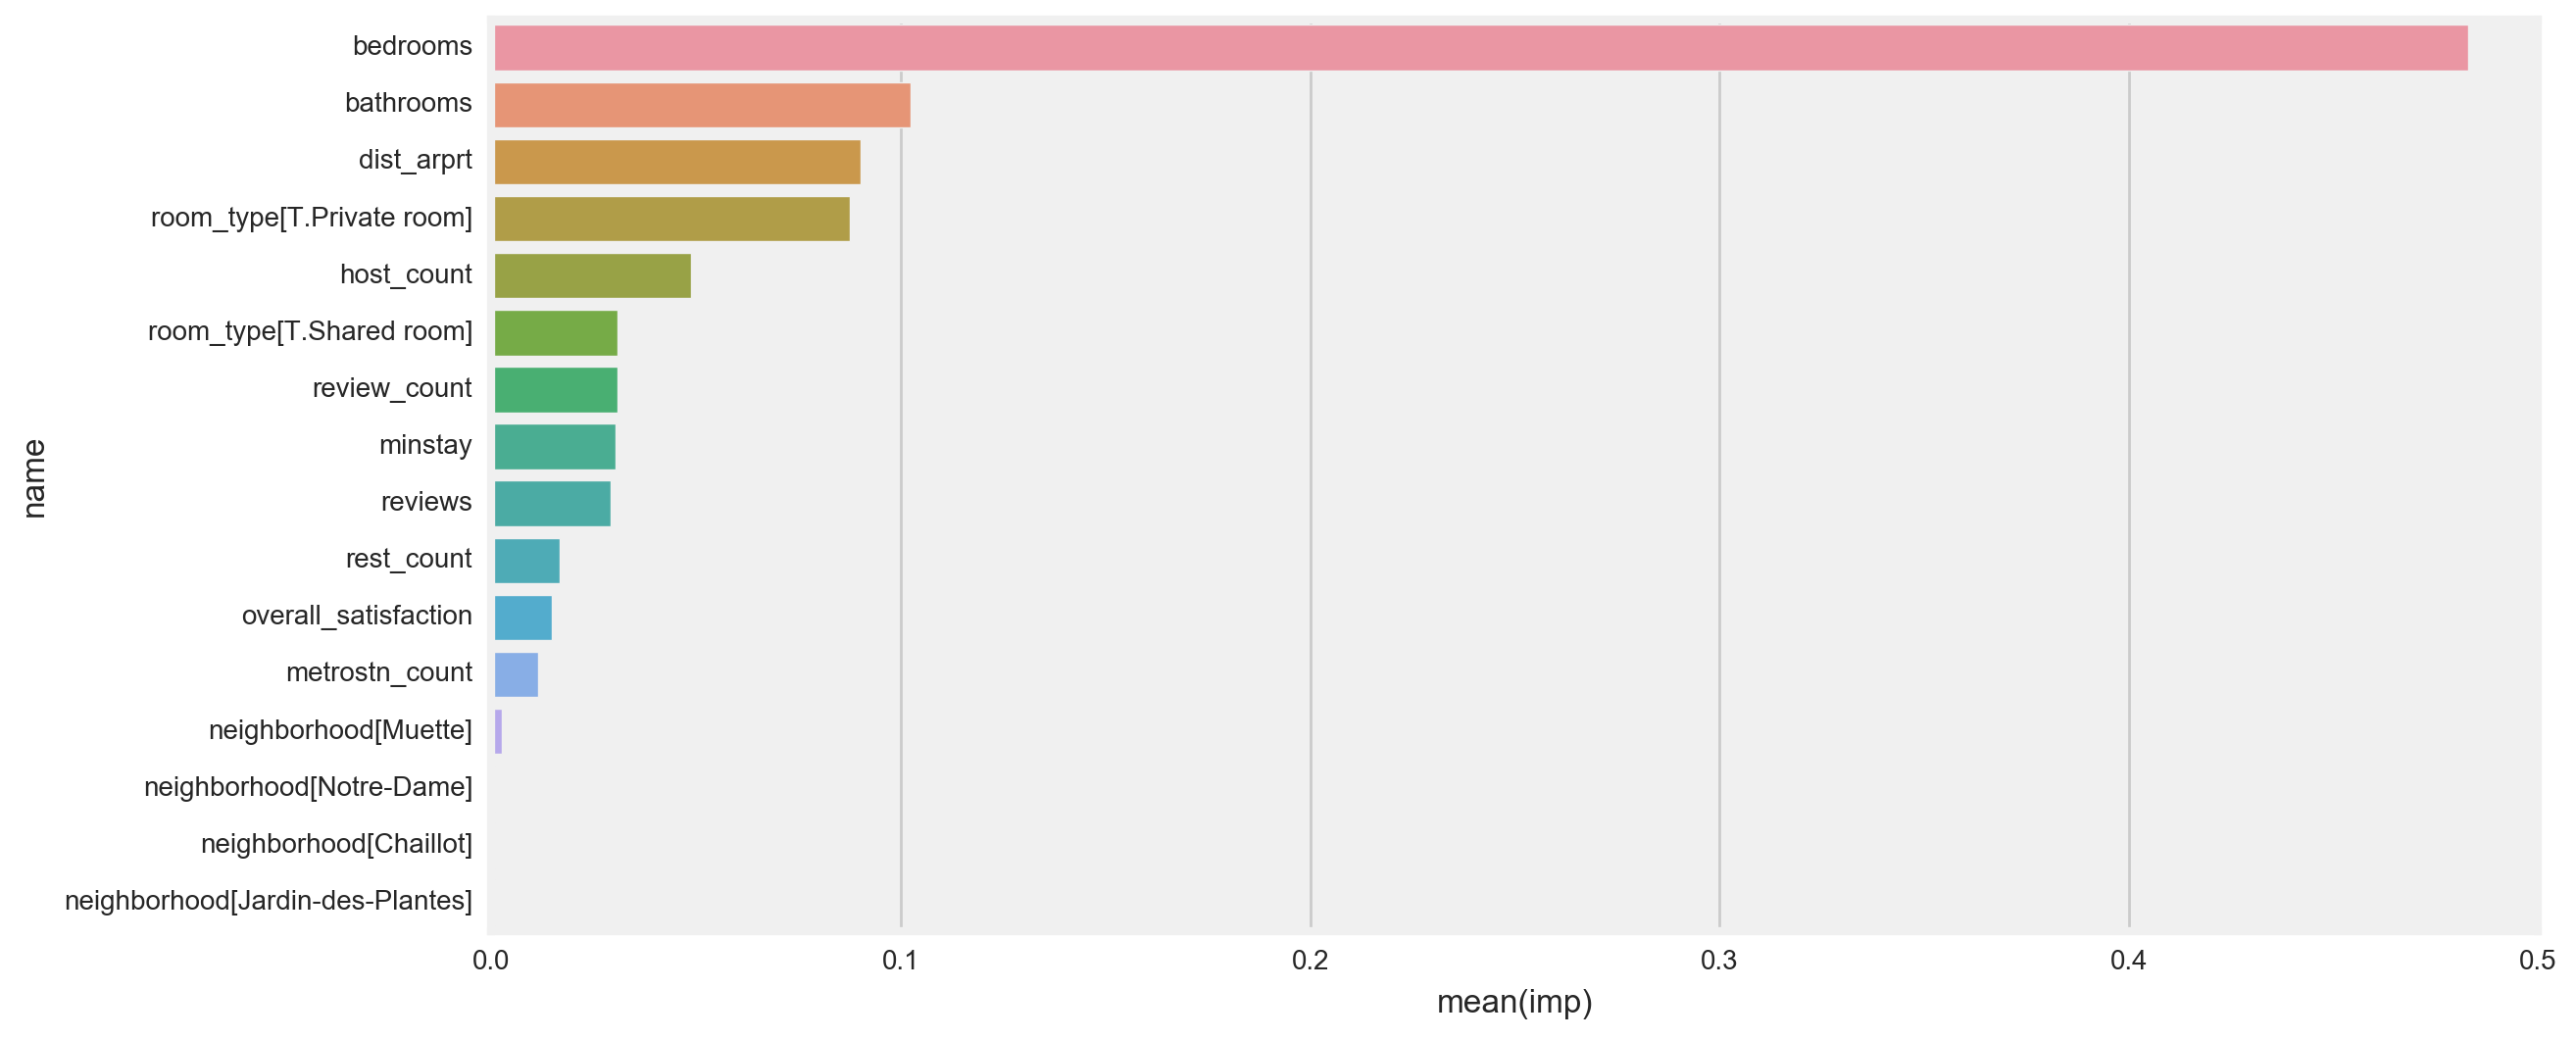

In [32]:
fig, ax = plt.subplots(figsize=(12,6))
# ax.bar(range(1,feature_val.shape[0]-77), feature_val.imp, 
#        tick_label=feature_val.name)
# ax.set_xticklabels(feature_val.name, rotation=90)

sns.barplot(y = feature_val.loc[0:15,:].name, x = feature_val.loc[0:15,:].imp, data=feature_val.loc[0:15,:],orient=""
           )
plt.show()